Sentence-Transformer have the same architecture based on Transformer architecture(BERT) -> Purposes using capture semantic meaning in the external knowledge  


In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import chromadb
import os
import uuid # For generating unique IDs

/media/tairo/Storages/AIProject/env/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-11 11:43:36.090755: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 11:43:36.247106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744346616.329922   87554 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744346616.354334   87554 cuda_bl

In [2]:
#File Path for datasset using for RAG
csv_files = [
    '/media/tairo/Storages/AIProject/DataSet/Chatbot/dataset - Coms.csv',
    '/media/tairo/Storages/AIProject/DataSet/Chatbot/dataset - Tomato Bacterial Spot.csv',
    '/media/tairo/Storages/AIProject/DataSet/Chatbot/dataset - Tomato Early Blight.csv',
    '/media/tairo/Storages/AIProject/DataSet/Chatbot/dataset - Tomato Yello Leaf Curl.csv'
]

In [3]:
#ChromaDB Setup 
CHROMA_DATA_PATH = "chroma_db_store" # Directory to store ChromaDB data
COLLECTION_NAME = "tomato_chatbot_knowledge" # Name for the collection

In [4]:
#Using embedding model For RAG
embedding_model_name = 'all-MiniLM-L6-v2' 

In [5]:
print(f"Using embedding model: {embedding_model_name}")
#Initialize the model download embedding model all miniLM L6 v2
model = SentenceTransformer(embedding_model_name)
print("Embedding model loaded.")

Using embedding model: all-MiniLM-L6-v2
Embedding model loaded.


In [6]:
all_dfs = [] #Create empty list to store dataframes for each individual loaded CSV file, before combined together
for file_path in csv_files: #Loop through 4 files
    if os.path.exists(file_path):
        try:
            print(f"Loading CSV: {os.path.basename(file_path)}...") #os.path.basename(file_path) to get the file name
            #Load the CSV file to the DataFrame
            df = pd.read_csv(file_path) #The DataFrame related to pandas(mostly use for reading CSV files) -> Core loading step in using  pd.read_csv(F)
            # Add a source column to know where the data came from
            df['source'] = os.path.basename(file_path)
            # Handle potential empty strings or NaN values in critical columns, will check for inside of its if empty will ''. The .astype(str) is use to ensure all text is treat as string
            df['Response'] = df['Response'].fillna('').astype(str)
            df['Intent'] = df['Intent'].fillna('Unknown').astype(str)
            df['User_Input'] = df['User_Input'].fillna('').astype(str)
            all_dfs.append(df)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    else:
        print(f"File not found - {file_path}")

if not all_dfs:
    print("No data loaded. Exiting.")
    exit()
    
# Combine all dataframes into one vertical stack Dataframe 

combined_df = pd.concat(all_dfs, ignore_index=True) 
print(f"\nCombined DataFrame created with {len(combined_df)} rows.")

# Clean up data - remove rows where the response (our document content) is empty
combined_df = combined_df[combined_df['Response'].str.strip() != '']
print(f"DataFrame size after removing empty responses: {len(combined_df)} rows.")

Loading CSV: dataset - Coms.csv...
Loading CSV: dataset - Tomato Bacterial Spot.csv...
Loading CSV: dataset - Tomato Early Blight.csv...
Loading CSV: dataset - Tomato Yello Leaf Curl.csv...

Combined DataFrame created with 220 rows.
DataFrame size after removing empty responses: 220 rows.


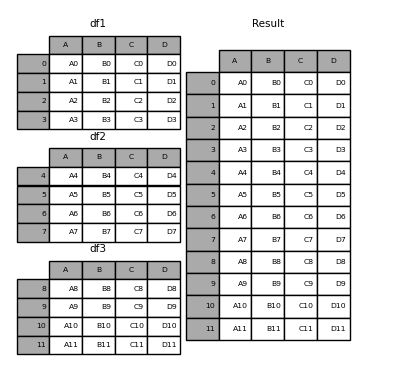  
Here is the example results of vertical stack dataframe after combine them all


In [7]:
# Prepare Data for ChromaDB
# Extract the text content (documents)
# Ensure documents are strings and handle potential None values again just in case
documents = combined_df['Response'].fillna('').astype(str).tolist()

# Extract metadata (as a list of dictionaries)
metadatas = combined_df[['source', 'Intent', 'User_Input']].to_dict(orient='records')

# Generate unique IDs for each document
# Using UUIDs is robust, but simple incremental IDs can also work if uniqueness is guaranteed
ids = [str(uuid.uuid4()) for _ in range(len(documents))]
# Alternative: ids = [f"doc_{i}" for i in range(len(documents))]

print(f"Prepared {len(documents)} documents, {len(metadatas)} metadata entries, and {len(ids)} IDs.")

Prepared 220 documents, 220 metadata entries, and 220 IDs.


In [8]:
# --- 4. Generate Embeddings ---
if documents:
    print("\nGenerating embeddings for documents...")
    # This is the most time-consuming step, especially on CPU
    embeddings = model.encode(documents, show_progress_bar=True).tolist()
    print(f"Generated {len(embeddings)} embeddings.")
else:
    print("No documents found to generate embeddings. Exiting.")
    exit()


Generating embeddings for documents...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

Generated 220 embeddings.


In [9]:
# --- 5. Initialize ChromaDB and Add Data ---
print(f"\nInitializing ChromaDB client (Persistent at: {CHROMA_DATA_PATH})...")
# Create a persistent client - data will be saved to the specified path
client = chromadb.PersistentClient(path=CHROMA_DATA_PATH)

print(f"Getting or creating collection: {COLLECTION_NAME}...")
# Get or create the collection.
# If the collection already exists with the same name, it will be loaded.
# If you rerun this script, you might want to delete the old collection first
# or handle potential duplicate IDs if using incremental IDs. UUIDs avoid this.
# Note: We are providing embeddings directly, so we don't strictly need to set
# the embedding_function here, but it can be good practice if you might add
# documents later without pre-calculating embeddings.
# For adding with pre-calculated embeddings, often you don't set it or use a default.
# Let's omit it for now as we provide embeddings directly. If Chroma complains,
# you might need `embedding_function=chromadb.utils.embedding_functions.SentenceTransformerEmbeddingFunction(model_name=embedding_model_name)`
collection = client.get_or_create_collection(name=COLLECTION_NAME)

# Add the data to the collection
# This might take a moment depending on the amount of data
print(f"Adding {len(documents)} documents to the collection...")
try:
    collection.add(
        embeddings=embeddings,
        documents=documents,
        metadatas=metadatas,
        ids=ids
    )
    print("Data successfully added to ChromaDB collection.")
except Exception as e:
    print(f"Error adding data to ChromaDB: {e}")
    # Consider potential issues like data type mismatches or connection problems


Initializing ChromaDB client (Persistent at: chroma_db_store)...
Getting or creating collection: tomato_chatbot_knowledge...
Adding 220 documents to the collection...
Data successfully added to ChromaDB collection.


In [10]:
# --- 6. Verification (Optional Query Example) ---
print("\n--- Verification Query ---")
if collection.count() > 0:
    try:
        query_text = "What causes bacterial spot on tomato?"
        print(f"Querying collection with: '{query_text}'")

        # Generate embedding for the query text
        query_embedding = model.encode([query_text]).tolist()

        results = collection.query(
            query_embeddings=query_embedding,
            n_results=2 # Get the top 2 most similar results
        )

        print("\nQuery Results:")
        if results and results.get('ids') and results['ids'][0]:
            for i in range(len(results['ids'][0])):
                print(f"  Result {i+1}:")
                print(f"    ID: {results['ids'][0][i]}")
                print(f"    Distance: {results['distances'][0][i]:.4f}") # Lower distance = more similar
                print(f"    Metadata: {results['metadatas'][0][i]}")
                # Truncate document for display
                doc_text = results['documents'][0][i]
                print(f"    Document: {doc_text[:250]}...") # Print first 250 chars
                print("-" * 20)
        else:
            print("No results found or results format unexpected.")

    except Exception as e:
        print(f"Error during verification query: {e}")
else:
    print("Collection is empty, skipping verification query.")

print("\n--- Preprocessing and Loading Complete ---")
print(f"ChromaDB data stored in: {os.path.abspath(CHROMA_DATA_PATH)}")
print(f"Collection name: {COLLECTION_NAME}")
print(f"Total documents in collection: {collection.count()}")


--- Verification Query ---
Querying collection with: 'What causes bacterial spot on tomato?'

Query Results:
  Result 1:
    ID: d0325a64-f0ed-4385-a7ff-46bddb8e3462
    Distance: 0.3224
    Metadata: {'Intent': 'Bacterial Spot', 'User_Input': 'What is the scientific name for the bacteria causing spot on my tomatoes?', 'source': 'dataset - Tomato Bacterial Spot.csv'}
    Document: Bacterial spot of tomato is caused by several species of the Xanthomonas bacteria, including:
- Xanthomonas vesicatoria
- Xanthomonas euvesicatoria
- Xanthomonas gardneri
- Xanthomonas perforans
These bacteria are often spread through contaminated se...
--------------------
  Result 2:
    ID: e39bd8d2-26ce-4f8b-81e8-fee57b324aa3
    Distance: 0.3224
    Metadata: {'Intent': 'Bacterial Spot', 'User_Input': 'What is the scientific name for the bacteria causing spot on my tomatoes?', 'source': 'dataset - Tomato Bacterial Spot.csv'}
    Document: Bacterial spot of tomato is caused by several species of the Xant

In [11]:
results = collection.query(
    query_embeddings=query_embedding,
    n_results=2
)
print(results)

{'ids': [['d0325a64-f0ed-4385-a7ff-46bddb8e3462', 'e39bd8d2-26ce-4f8b-81e8-fee57b324aa3']], 'embeddings': None, 'documents': [['Bacterial spot of tomato is caused by several species of the Xanthomonas bacteria, including:\n- Xanthomonas vesicatoria\n- Xanthomonas euvesicatoria\n- Xanthomonas gardneri\n- Xanthomonas perforans\nThese bacteria are often spread through contaminated seeds or rain splash, and can lead to dark, water-soaked lesions on the leaves and fruit. Do you want to know any tips  or way to prevent', 'Bacterial spot of tomato is caused by several species of the Xanthomonas bacteria, including:\n- Xanthomonas vesicatoria\n- Xanthomonas euvesicatoria\n- Xanthomonas gardneri\n- Xanthomonas perforans\nThese bacteria are often spread through contaminated seeds or rain splash, and can lead to dark, water-soaked lesions on the leaves and fruit. Do you want to know any tips  or way to prevent']], 'uris': None, 'data': None, 'metadatas': [[{'Intent': 'Bacterial Spot', 'User_Input